# Assigment 3


## Upload your code on Learn dropbox and submit pdfs of the code and answers to the mathematical questions on Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Load modules

In [1]:
# !pip install numpy, scipy, scikit-image, skimage, matplotlib

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import data
from skimage.transform import resize

# Numpy is useful for handling arrays and matrices.
import numpy as np
from scipy import sparse as sp
from scipy.sparse import linalg
from scipy.sparse.linalg import eigsh
import time

## Load image

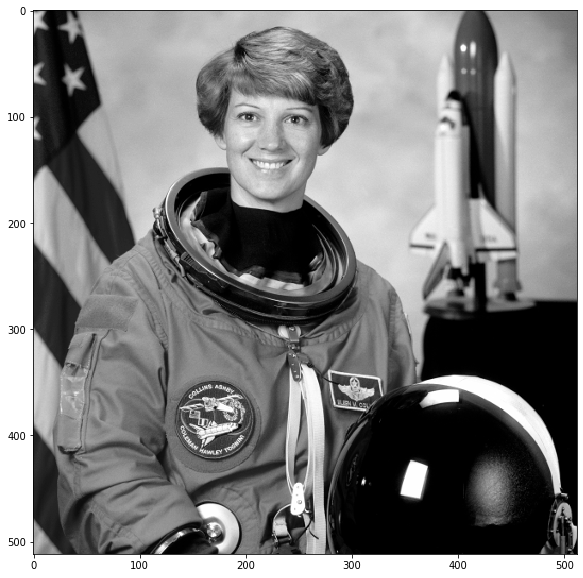

In [2]:
img = data.astronaut()
img = rgb2gray(img)*255 # convert to gray and change scale from (0,1) to (0,255).

n = img.shape[0]

plt.figure(1, figsize=(10, 10))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Compute the differences operators here. Use your code from Assignment 2.

In [3]:
# You will need these three methods to construct sparse differences operators.
# If you do not use sparse operators you might have scalability problems.
from scipy.sparse import diags
from scipy.sparse import kron
from scipy.sparse import identity

# Use your code from Assignment 2. 
# Make sure that you compute the right D_h and D_v matrices.
J = diags([1, -1], [0, 1], shape = (n, n)).tocsr()
I = identity(n).tocsr()
D_h = kron(J, I).tocsr()
D_v = kron(I, J).tocsr()

print('Done constructing the differences operators')
print('Dimensions:')
print('n^2:', n ** 2)
print('D_h:', D_h.shape)
print('D_v:', D_v.shape)

Done constructing the differences operators
Dimensions:
n^2: 262144
D_h: (262144, 262144)
D_v: (262144, 262144)


## Add noise to the image

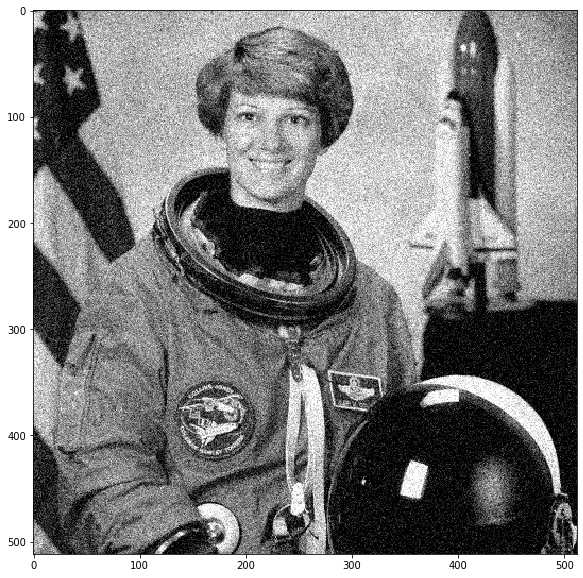

In [4]:
mean_ = 0
standard_deviation = 30
dimensions = (n,n)

noise = np.random.normal(mean_,standard_deviation,dimensions)

noisy_image = img + noise

plt.figure(1, figsize=(10, 10))
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.show()

In [5]:
#Constants used throughout the assignment
I = identity(n * n).tocsr()
D = D_h + 1j * D_v
realD = D_h.transpose() * D_h + D_v.transpose() * D_v
z = np.reshape(noisy_image, (n * n, 1))
z = sp.csr_matrix(z)
Ones = np.ones((n ** 2, 1))
Ones = sp.csr_matrix(Ones)

lambda_ = 25
epsilon = 1.0e-2
max_iterations = 100
u = 0.1
gamma = 0.14
x0 = np.reshape(noisy_image, (n * n, 1))
x0 = sp.csr_matrix(x0)

#Variables to store data for plotting
armijoData = []
lineSearchData = []
accelData = []
practicalData = []

In [6]:
def pseudoHuber(x, z, lambda_, u):
    ps = sp.csr_matrix.sqrt((u ** 2 * Ones + (abs(D * x)).power(2))) - u * Ones
    return lambda_ * sp.csr_matrix.sum(ps) + (1/2) * sp.linalg.norm(x - z) ** 2

def gradientPseudoHuber(x, z, lambda_, u):
    Dhx = D_h * x
    Dvx = D_v * x
    DhxSqr = Dhx.power(2) 
    DvxSqr = Dvx.power(2)
    uSqr = u ** 2 * Ones
    denom = sp.csr_matrix.sqrt(uSqr + DhxSqr + DvxSqr)
    return lambda_ * sp.csr_matrix(D_h.T * (Dhx / denom) + D_v.T * (Dvx / denom)) + x - z

def minError(zOutput):
    if (sp.issparse(zOutput)): zOutput = zOutput.todense()
    zClean = np.reshape(img, (n * n, 1))
    return np.linalg.norm(zOutput - zClean) / (n ** 2)

## Question 1 (8 marks): implement gradient descent with Armijo line-search for the Total-Variation denoising problem. Use the pseudo-Huber function to smooth the problem. 

In [7]:
#def line_search_armijo(x, D, Dx, vec_image, grad_reg, grad_fit, lambda_, gamma):
def armijo_line_search(x, z, gradF, grad_fit, lambda_, gamma, u):
    
# x0:       is the initial guess for the x variables
# z:        is the vectorized noisy image
# grad_fit: is the gradient of the least-squares term ||x-vec_image||_2^2
# lambda_:  is the regularization parameter of the denoising problem.
# gamma:    parameter of Armijo line-search as was defined in the lectures.
# u:        mue value used for pseudo huber functions

    alpha = 1
    fxk = pseudoHuber(x, z, lambda_, u)
    gradFL2Norm = sp.linalg.norm(gradF) ** 2
    
    rightSide = fxk - alpha * gamma * gradFL2Norm
    leftSide = x - alpha * gradF

    #f(xk - a*gradf(xk)):
    fLeftSide = pseudoHuber(leftSide, z, lambda_, u)
    
    while(fLeftSide > rightSide):
        alpha = alpha / 2
        rightSide = fxk - alpha * gamma * gradFL2Norm
        leftSide = x - alpha * gradF
        fLeftSide = pseudoHuber(leftSide, z, lambda_, u)
    return alpha

def armijo_gradient_descent(x0, epsilon, lambda_, max_iterations, gamma, u):

# x0:             is the initial guess for the x variables
# epsilon:        is the termination tolerance parameter
# lambda_:        is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.
# gamma:          parameter of Armijo line-search as was defined in the lectures.
# u:              mue value used for pseudo huber functions
    xCurrent = x0
    armijoData.append(xCurrent)
    
    for i in range (max_iterations):
        gradF = gradientPseudoHuber(xCurrent, z, lambda_, u)
        grad_fit = sp.linalg.norm(xCurrent - z) ** 2
        
        alpha = armijo_line_search(xCurrent, z, gradF, grad_fit, lambda_, gamma, u)
        
        xNext = xCurrent - alpha * gradF
        armijoData.append(xNext)
        
        if (sp.linalg.norm(gradF) < epsilon):
            return xNext
        else:
            xCurrent = xNext
    return xNext

In [8]:
x = armijo_gradient_descent(x0, epsilon, lambda_, max_iterations, gamma, u)
print('done')

x = x.todense()

print(minError(x))

0
100
200
300
400
500
600
700
800
900
done
0.01962699428899436


In [8]:
#Picking mu and lambda
uList = [0.01]
lambda_start = 30
for i in range(0, len(uList)):
    for j in range(20):
        lambda_used = lambda_start + j
        t0 = time.time()
        x = armijo_gradient_descent(x0, epsilon, lambda_used, max_iterations, gamma, uList[i])
        t1 = time.time()
        x = x.todense()
        error = minError(x)
        print("time=", round(t1 - t0, 2), "sec", "error=", round(error,7) , "lambda=", lambda_used, "mu=", uList[i])  

time= 65.39 sec error= 0.0201122 lambda= 30 mu= 0.01
time= 65.89 sec error= 0.0199634 lambda= 31 mu= 0.01
time= 65.42 sec error= 0.0199798 lambda= 32 mu= 0.01
time= 65.32 sec error= 0.0198738 lambda= 33 mu= 0.01
time= 65.41 sec error= 0.0197621 lambda= 34 mu= 0.01
time= 66.09 sec error= 0.0196635 lambda= 35 mu= 0.01
time= 66.36 sec error= 0.0195743 lambda= 36 mu= 0.01
time= 65.68 sec error= 0.0195684 lambda= 37 mu= 0.01
time= 65.74 sec error= 0.01952 lambda= 38 mu= 0.01
time= 65.98 sec error= 0.0194627 lambda= 39 mu= 0.01
time= 66.24 sec error= 0.0194145 lambda= 40 mu= 0.01
time= 66.5 sec error= 0.019364 lambda= 41 mu= 0.01
time= 66.92 sec error= 0.0193311 lambda= 42 mu= 0.01
time= 66.84 sec error= 0.019298 lambda= 43 mu= 0.01
time= 67.19 sec error= 0.0192809 lambda= 44 mu= 0.01
time= 66.86 sec error= 0.019264 lambda= 45 mu= 0.01
time= 67.3 sec error= 0.0192584 lambda= 46 mu= 0.01
time= 67.6 sec error= 0.0192571 lambda= 47 mu= 0.01
time= 67.86 sec error= 0.0192633 lambda= 48 mu= 0.01
t

## Call Gradient Descent with Armijo line-search to denoise the image. Parameter tunning is not given for this assignment. You will have to tune all parameters yourself. Regarding the quality of the output image, pick the $\lambda$ parameter that makes the error $$\frac{1}{n^2}\|z_{output} - z_{clean}\|_2$$ as small as possible, where $z_{output}$ is the output of the algorithm. Find $\lambda$ by trial and error. Note that the smoothing parameter $\mu$ affects the quality of the output as well. Pick $\mu$ small enough such that the above error does not improve much for smaller values of $\mu$. I will measure the running time only for your chosen parameters $\lambda$ and $\mu$, therefore, make sure to seperate any code that does trial and error and the code that reports the result for the chosen parameters.

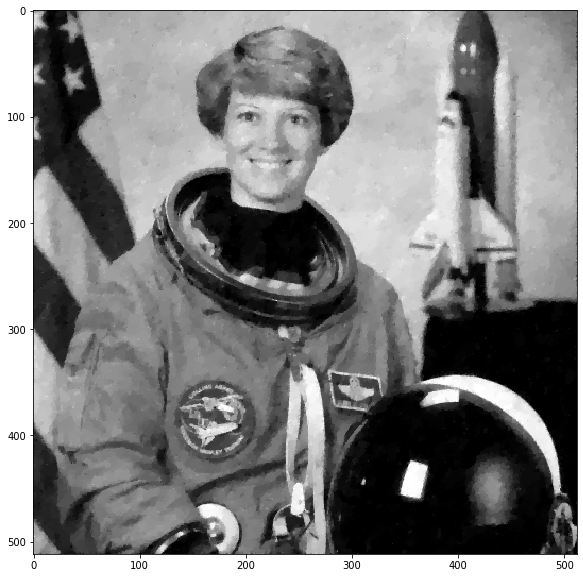

In [9]:
xImg = x.reshape(img.shape)
plt.figure(1, figsize=(10, 10))
plt.imshow(xImg, cmap='gray', vmin=0, vmax=255)
plt.show()

## Question 2 (5 marks): implement gradient descent with simple line-search for the Total-Variation denoising problem. Use the pseudo-Huber function to smooth the problem.

In [8]:
# write your code here
#def line_search(x, D, Dx, vec_image, grad_reg, grad_fit, lambda_, gamma):
def line_search(x, z, gradF, grad_fit, lambda_, u):
    
# x:        is the initial guess for the x variables
# z:        is the vectorized noisy image
# grad_fit: is the gradient of the least-squares term ||x-vec_image||_2^2
# lambda_:  is the regularization parameter of the denoising problem.
# u:        mue value used for pseudo huber functions

    alpha = 1
    fxk = pseudoHuber(x, z, lambda_, u)
    gradFL2Norm = sp.linalg.norm(gradF) ** 2
    
    leftSide = x - alpha * gradF

    #f(xk - a*gradf(xk)):
    fLeftSide = pseudoHuber(leftSide, z, lambda_, u)
    
    while(fLeftSide > fxk):
        alpha = alpha / 2
        leftSide = x - alpha * gradF
        fLeftSide = pseudoHuber(leftSide, z, lambda_, u)
    return alpha

def gradient_descent(x0, epsilon, lambda_, max_iterations, u):

# x0:             is the initial guess for the x variables
# epsilon:        is the termination tolerance parameter
# lambda_:        is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.
# u:              mue value used for pseudo huber functions
    xCurrent = x0
    lineSearchData.append(xCurrent)
    
    for i in range (max_iterations):
        gradF = gradientPseudoHuber(xCurrent, z, lambda_, u)
        grad_fit = sp.linalg.norm(xCurrent - z) ** 2
    
        alpha = line_search(xCurrent, z, gradF, grad_fit, lambda_, u)
        
        xNext = xCurrent - alpha * gradF
        lineSearchData.append(xNext)
        
        if (sp.linalg.norm(gradF) < epsilon):
            return xNext
        else:
            xCurrent = xNext
    return xNext

## Call gradient descent with simple line-search to denoise the image. Use the same $\lambda$ and $\mu$ that you used in Q1. 

In [11]:
x = gradient_descent(x0, epsilon, lambda_, max_iterations, u)
print('done')

x = x.todense()
print(minError(x))

0
100
200
300
400
500
600
700
800
900
done
0.01963389673792892


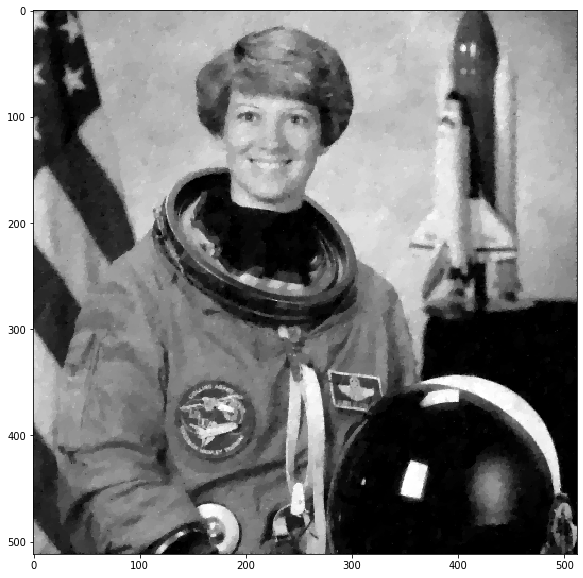

In [12]:
xImg = x.reshape(img.shape)
plt.figure(1, figsize=(10, 10))
plt.imshow(xImg, cmap='gray', vmin=0, vmax=255)
plt.show()

## Question 3 (6 marks): Compute a Lipschitz constant for the smoothed Total-Variation problem. Note the Lipschitz constant is not unique. However, the minimum Lipschitz constant will give you better performance in algorithms compared to larger Lipschitz constants. This means that whatever you compute here will affect the running time of your algorithm in Q4.

In [13]:
A = lambda_ * realD + I
eigenvalues = eigsh(A, k = 1, return_eigenvectors = False)
L = eigenvalues[0]
L = L/u + 1
print(L)

## Question 4 (8 marks): implement accelerated gradient for the Total-Variation denoising problem. Use the pseudo-Huber function to smooth the problem. Use the Lipschitz constant that you obtained in Q3. Do not include computation of the Lipschitz constant in this question. You can do it in Q3 and the time for computing the Lipschitz constant will not be taken into account.

In [9]:
def accel_gradient_descent(x0, epsilon, lambda_, max_iterations, u):
# x0:             is the initial guess for the x variables
# epsilon:        is the termination tolerance parameter
# lambda_:        is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.
# gamma:          parameter of Armijo line-search as was defined in the lectures.
# u:              mue value used for pseudo huber functions
    L = 2010.9812119956864
    
    zCurrent = x0
    lambdaK = 1
    xCurrent = x0
    
    accelData.append(xCurrent)
    for i in range(max_iterations):
        if (i < 4):
            gamma = 0
        else:
            gamma = 2/i
            
        lambdaK = lambdaK*(1 - gamma)
        y = (1 - gamma) * xCurrent + gamma * zCurrent
        
        gradF = gradientPseudoHuber(y, z, lambda_, u)
        
        zNext = zCurrent - (gamma/lambdaK) * (1/L) * gradF
        xNext = y - (1/L) * gradF
        accelData.append(xNext)
        
        if (linalg.norm(gradientPseudoHuber(xNext, z, lambda_, u)) < epsilon):
            return xNext
        else:
            xCurrent = xNext
            zCurrent = zNext
    return xNext

## Call accelerated gradient to denoise the image. Use the same $\lambda$ and $\mu$ that you used in Q1.

In [15]:
# write your code here
x = accel_gradient_descent(x0, epsilon, lambda_, max_iterations, u)
print('done')

x = x.todense()
print(minError(x))

0
100
200
300
400
500
600
700
800
900
done
0.019685299256089535


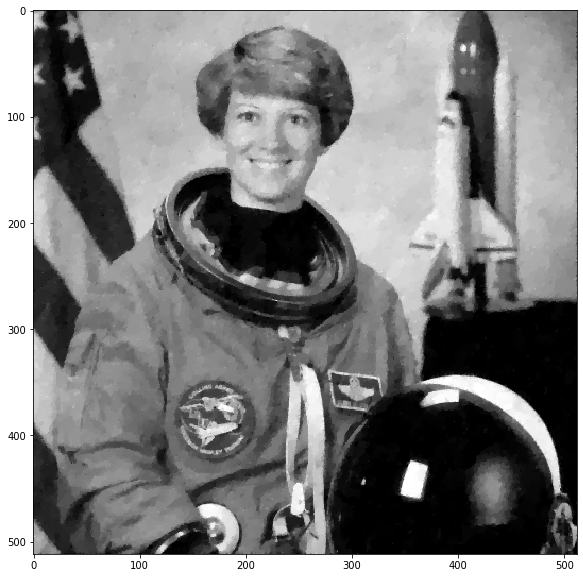

In [16]:
xImg = x.reshape(img.shape)
plt.figure(1, figsize=(10, 10))
plt.imshow(xImg, cmap='gray', vmin=0, vmax=255)
plt.show()

## Question 5 (10 marks): in Q4 you were asked to implement accelerated gradient by using constant step-sizes $1/L.$ However, computing the Lipschitz constant might take a lot of time and it often results in slow convergence because the step-sizes are too small. Below I give you a practical accelerated method that does not require knowing the Lipschitz constant. The step-sizes $$\alpha_k$$ in this algorithm can be computed using Armijo line-search. Implement this algorithm for the Total-Variation denoising problem. Use the pseudo-Huber function to smooth the problem. 

Step 1) Choose an $x_0$ and set $y_1=x_0$, $t_1=1$.

Step 2) Repeat the following steps until $\|\nabla f(x_k)\|_2\le \epsilon$

Step 3) Compute $\alpha_k$ using Armijo line-search. Armijo line-search should be measured at $y_k-\alpha_k \nabla f(y_k)$ (as the next point) and $y_k$ (as the current point).

Step 4) Set $$x_{k}=y_k - \alpha_k \nabla f(y_k)$$

Step 5) Set $$t_{k+1}=\frac{1 + \sqrt{1+4t_k^2}}{2}$$

Step 6) Set $$y_{k+1}=x_k + \frac{t_k-1}{t_{k+1}}(x_k-x_{k-1})$$

Reference: this algorithm is given in "A Fast Iterative Shrinkage-Thresholding Algorithm for Linear Inverse Problems" by A. Beck and M. Teboulle.
===================== 

In [10]:
# Write your code here
def practical_line_search(y, z, gradF, lambda_, u):
# y:        is the initial guess for the y variables
# z:        is the vectorized noisy image
# grad_fit: is the gradient of the least-squares term ||x-vec_image||_2^2
# lambda_:  is the regularization parameter of the denoising problem.
# u:        mue value used for pseudo huber functions
    alpha = 1
    fyk = pseudoHuber(y, z, lambda_, u)
    gradFL2Norm = sp.linalg.norm(gradF) ** 2
    
    rightSide = fyk - alpha * gamma * gradFL2Norm
    leftSide = y - alpha * gradF

    #f(xk - a*gradf(xk)):
    fLeftSide = pseudoHuber(leftSide, z, lambda_, u)
    
    while(fLeftSide > rightSide):
        alpha = alpha / 2
        rightSide = fyk - alpha * gamma * gradFL2Norm
        leftSide = y - alpha * gradF
        fLeftSide = pseudoHuber(leftSide, z, lambda_, u)
    return alpha
    
    
def practical_accel_gradient_descent(x0, epsilon, lambda_, max_iterations, u):
    yCurrent = x0
    xCurrent = x0
    tCurrent = 1
    
    practicalData.append(xCurrent)
    for i in range(max_iterations):
        gradF = gradientPseudoHuber(yCurrent, z, lambda_, u)
        alpha = practical_line_search(yCurrent, z, gradF, lambda_, u)
        
        xNext = yCurrent - alpha * gradF
        practicalData.append(xNext)
        
        tNext = (1 + np.sqrt(1 + 4 * tCurrent ** 2)) / 2
        
        yCurrent = xNext + ((tCurrent - 1)/tNext) * (xNext - xCurrent)
        
        if (linalg.norm(gradientPseudoHuber(xNext, z, lambda_, u)) < epsilon):
            return xNext
        else:
            xCurrent = xNext
            tCurrent = tNext
    return xNext

## Call the practical accelerated gradient to denoise the image. Use the same $\lambda$ and $\mu$ that you used in Q1.

In [18]:
# write your code here
x = practical_accel_gradient_descent(x0, epsilon, lambda_, max_iterations, u)
print('done')

x = x.todense()
print(minError(x))

0
100
200
300
400
500
600
700
800
900
done
0.020458647132114826


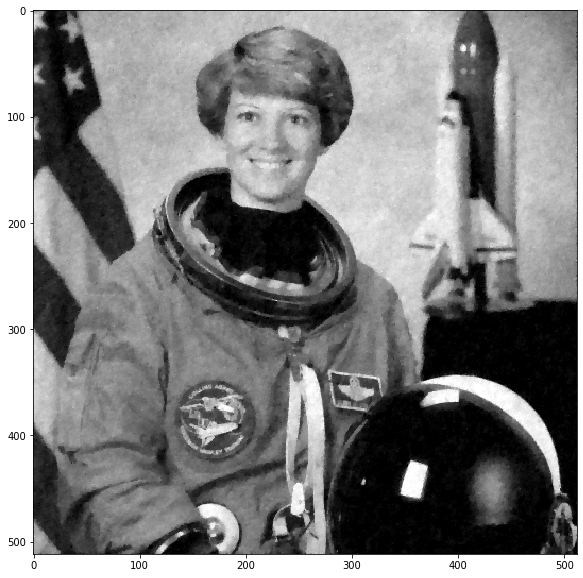

In [19]:
xImg = x.reshape(img.shape)
plt.figure(1, figsize=(10, 10))
plt.imshow(xImg, cmap='gray', vmin=0, vmax=255)
plt.show()

## Question 6 (5 marks): Compare all the methods that you implemented above. Make a plot where in the y-axis is the value of the smoothed objective function and in the x-axis the number of iterations. Compare the methods using the same $\lambda$ and $\mu$ that you used in Q1.

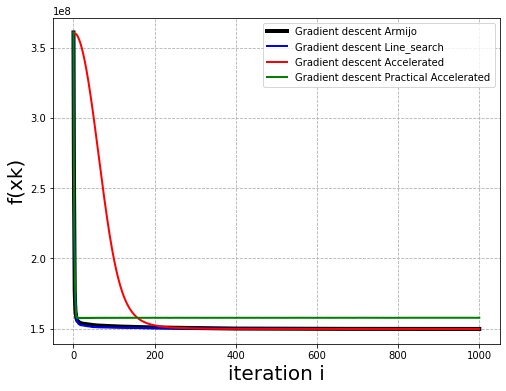

In [21]:
# Write your code here.
def createData(data):
    plot = np.zeros((len(data), 2))
    for i in range(len(data)):
        plot[i, 0] = i
        plot[i, 1] = pseudoHuber(data[i], z, lambda_, u)
    return plot
#Armijio Gradient Descent
armijoPlot = createData(armijoData)

#Line search
lineSearchPlot = createData(lineSearchData)

#Accelerated
accelPlot = createData(accelData)

#practical
practicalPlot = createData(practicalData)

fig = plt.figure(figsize=(8, 6))

plt.plot(armijoPlot[:,0], armijoPlot[:,1], label = "Gradient descent Armijo", linewidth = 4.0, color = "black")
plt.plot(lineSearchPlot[:,0], lineSearchPlot[:,1], label = "Gradient descent Line_search", linewidth = 2.0, color = "blue")
plt.plot(accelPlot[:,0], accelPlot[:,1], label = "Gradient descent Accelerated", linewidth = 2.0, color = "red")
plt.plot(practicalPlot[:,0], practicalPlot[:,1], label = "Gradient descent Practical Accelerated", linewidth = 2.0, color = "green")

plt.legend(loc = "upper right")
plt.xlabel("iteration i", fontsize = 20)
plt.ylabel("f(xk)", fontsize = 20)
plt.grid(linestyle = 'dashed')
plt.show()

## Question 7 (8 marks): Illustrate the trade-off between the number of iterations and the smoothing parameter $\mu$ for gradient descent with Armijo line-search and accelerated gradient with Armijo line-search. Do this by plotting the number of iterations (y-axis) vs magnitude of parameter $\mu$ (x-axis in ascending order). Start from a small $\mu$ and increase it gradually. Plot the result for both methods in the same plot. Use appropriate legends for the plot.

In [11]:
# Write your code here.
def armijo_gradient_descent_iter(x0, epsilon, lambda_, max_iterations, gamma, u):

# x0:             is the initial guess for the x variables
# epsilon:        is the termination tolerance parameter
# lambda_:        is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.
# gamma:          parameter of Armijo line-search as was defined in the lectures.
# u:              mue value used for pseudo huber functions
    xCurrent = x0
    iterArmijo.append(xCurrent)
    
    for i in range (max_iterations):
        gradF = gradientPseudoHuber(xCurrent, z, lambda_, u)
        grad_fit = sp.linalg.norm(xCurrent - z) ** 2
        
        alpha = armijo_line_search(xCurrent, z, gradF, grad_fit, lambda_, gamma, u)
        
        xNext = xCurrent - alpha * gradF
        iterArmijo.append(xNext)
        
        if (sp.linalg.norm(gradF) < epsilon):
            return i + 1
        else:
            xCurrent = xNext
    return i + 1

def practical_accel_gradient_descent_iter(x0, epsilon, lambda_, max_iterations, u):
    yCurrent = x0
    xCurrent = x0
    tCurrent = 1
    
    iterAccelArmijo.append(xCurrent)
    for i in range(max_iterations):
        gradF = gradientPseudoHuber(yCurrent, z, lambda_, u)
        alpha = practical_line_search(yCurrent, z, gradF, lambda_, u)
        
        xNext = yCurrent - alpha * gradF
        iterAccelArmijo.append(xNext)
        
        tNext = (1 + np.sqrt(1 + 4 * tCurrent ** 2)) / 2
        
        yCurrent = xNext + ((tCurrent - 1)/tNext) * (xNext - xCurrent)
        
        if (linalg.norm(gradientPseudoHuber(xNext, z, lambda_, u)) < epsilon):
            return i + 1
        else:
            xCurrent = xNext
            tCurrent = tNext
    return i + 1

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


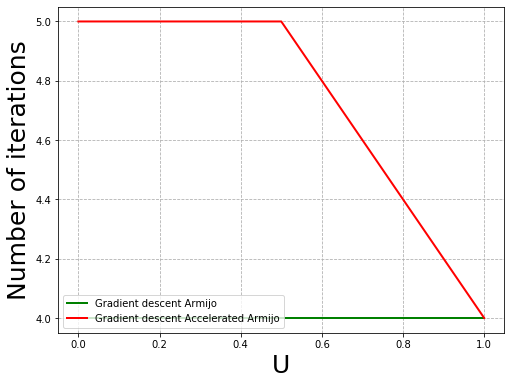

In [16]:
uList = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
plotArmijo = np.zeros((len(uList), 2))
plotPractical = np.zeros((len(uList), 2))
epsilon = 15000

for i in range (len(uList)):
    plotArmijo[i, 0] = uList[i]
    plotPractical[i, 0] = uList[i]
    
    plotArmijo[i, 1] = armijo_gradient_descent_iter(x0, epsilon, lambda_, max_iterations, gamma, uList[i])
    plotPractical[i, 1] = practical_accel_gradient_descent_iter(x0, epsilon, lambda_, max_iterations, uList[i])

fig = plt.figure(figsize=(8, 6))
plt.plot(plotArmijo[:,0], plotArmijo[:,1], label=("Gradient descent Armijo"), linewidth=2.0, color ="green")
plt.plot(plotPractical[:,0], plotPractical[:,1], label=("Gradient descent Accelerated Armijo"), linewidth=2.0, color ="red")

plt.legend(prop={'size': 10},loc="lower left")
plt.xlabel("U", fontsize=25)
plt.ylabel("Number of iterations", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Mathematical Questions

## Question 8 (5 marks): Derive a smooth approximation (Huber function) of the L1-norm using the convex conjugate of the L1-norm and the distance function $$d(y)=\frac{1}{2}\|y\|_2^2.$$

## Question 9 (7 marks): Derive the pseudo-Huber function using the convex conjugate of the L1-norm.  To derive the pseudo-Huber use the distance function $$d(y)=\sum_{i=1}^n 1 - \sqrt{1-y_i^2}$$ with domain $$|y_i|\le 1 \ \ \forall i.$$

## Question 10 (3 marks): Show that the pseudo-Huber function is convex and not strongly-convex.

## Question 11 (7 marks): If the convex conjugate of $f$ is strongly-convex with compact convex domain then $$\max_{y \in \mbox{dom} \ f^*} x^Ty - f^*(y)$$ has a unique maximizer. Assume that $f$ is convex and show that  $$\nabla f(x) =\mbox{argmax}_{y \in \mbox{dom} \ f^*} x^Ty - f^*(y).$$ Hint: one approach to solve this is to lower and upper bound $f$ and then use the definition of directional derivative.

## Question 12 (7 marks): Prove that if the convex conjugate of $f$ is $\delta$-strongly-convex, then $\nabla f(x)$ is Lipschitz continuous with Lipschitz constant $1/\delta.$

## Question 13 (8 marks):  Assume that the domain of the convex conjugate satisfies $$\mbox{dom} \ f^* \subseteq \mathbb{R}^n.$$ and it is closed and bounded. Also, assume that $f$ is convex. You are given a continuous distance function $d(y)$ where its domain satisfies $$\mbox{dom} \ f^* \subseteq \mbox{dom} \ d .$$ Prove that $$f(x) - \mu D \le f_\mu(x) \le f(x),$$ where $D$ has to be bounded and $f_\mu(x)$ is the smooth approximation of $f$. See slides 54-57 in Lecture07and08 on piazza. Hint: you will need the Weierstrass extreme value theorem to show that $D$ is bounded.

## ## Question 14 (8 marks): We proved that for any convex function with Lipschitz continuous gradient there exists and estimate sequence. Show that for an estimate sequence we have that $$f(x_k) - f^* = \mathcal{O}\left(\frac{1}{k^2}\right)$$

## Question 15 (5 marks): Obtain the convergence rate and iteration complexity for the accelerated method for strongly-convex functions with Lipschitz continuous gradient.